{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'ID': 231, 'type': 'NATIVE', 'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M

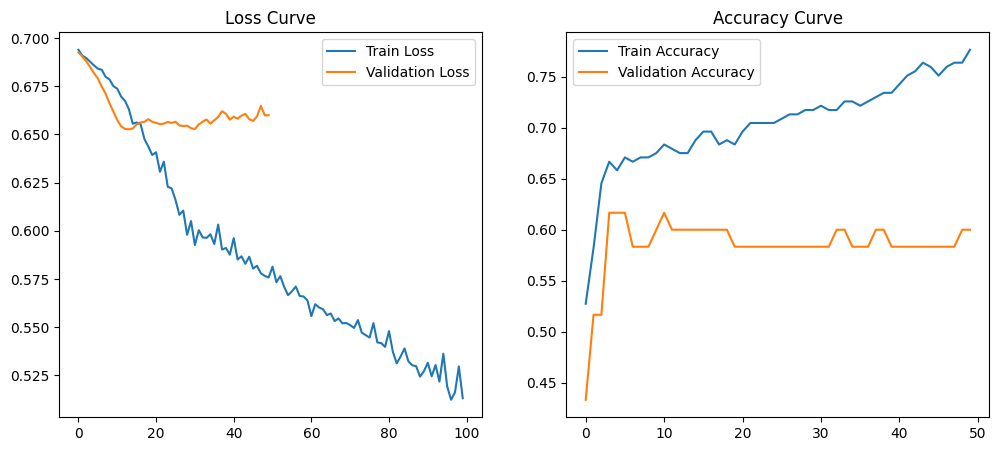


===== FINAL METRICS =====
Accuracy: 0.5833333333333334
Precision: 0.55
Recall: 0.4074074074074074
F1 Score: 0.46808510638297873
AUC: 0.6756453423120089

Confusion Matrix:
 [[24  9]
 [16 11]]


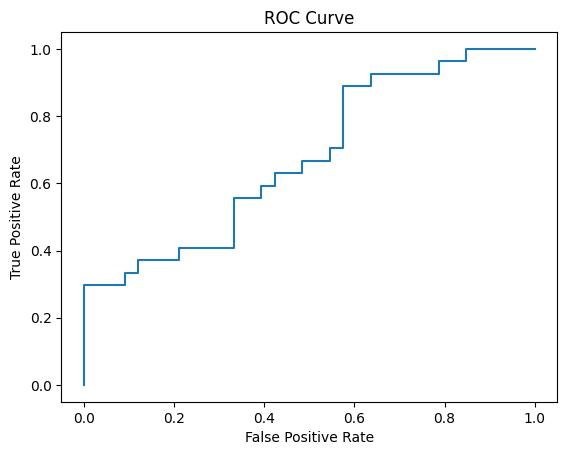

In [ ]:
# ============================================================
# INSTALL DEPENDENCIES
# ============================================================
!pip install ucimlrepo torch numpy pandas scikit-learn matplotlib

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt


# ============================================================
# LOAD UCI HEART DISEASE DATASET
# ============================================================
heart_disease = fetch_ucirepo(id=45)

X = heart_disease.data.features
y = heart_disease.data.targets

print(heart_disease.metadata)
print(heart_disease.variables)

# Convert target to clean binary format
y = y.squeeze()                        # remove extra dimension
y = (y > 0).astype(np.float32)         # convert to binary 0/1

X = X.replace("?", np.nan)                # replace '?' with NaN
X = X.apply(pd.to_numeric, errors="coerce")  # convert all to numbers
X = X.dropna().reset_index(drop=True)
y = y.loc[X.index].reset_index(drop=True)


# ============================================================
# TRAIN/TEST SPLIT
# ============================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train = X_train.reset_index(drop=True)
X_test  = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test  = y_test.reset_index(drop=True)

# ============================================================
# NORMALIZATION
# ============================================================
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors (correct shape!)
# X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
# Convert y_train and y_test to float32 tensors
# y_train_tensor = torch.tensor(y_train.astype(np.float32)).view(-1, 1)
# y_test_tensor  = torch.tensor(y_test.astype(np.float32)).view(-1, 1)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.astype(np.float32)).view(-1, 1)
y_test_tensor  = torch.tensor(y_test.values.astype(np.float32)).view(-1, 1)

# ============================================================
# NEURAL NETWORK MODEL
# ============================================================
class HeartNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(13, 32),
            nn.LeakyReLU(0.01),
            nn.Linear(32, 16),
            nn.LeakyReLU(0.01),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


# ============================================================
# TRAINING FUNCTION
# ============================================================
def train_model(model, lr, batch_size, epochs, weight_decay):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    dataset = TensorDataset(X_train_tensor, y_train_tensor)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for Xb, yb in loader:
            optimizer.zero_grad()
            preds = model(Xb)

            if torch.isnan(preds).any():
              print("❌ NaN detected in forward pass!")
              return train_losses, val_losses, train_accs, val_accs
            # FIX: ensure the preds are safe (no values = 0 or 1 exactly)
            loss = criterion(preds, yb)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(loader))

        # Validation
        model.eval()
        with torch.no_grad():
          # --- Probabilities (NO rounding for loss) ---
          train_probs = model(X_train_tensor)
          val_probs = model(X_test_tensor)

          # --- Losses ---
          train_loss = criterion(train_probs, y_train_tensor).item()
          val_loss = criterion(val_probs, y_test_tensor).item()

          train_losses.append(train_loss)
          val_losses.append(val_loss)

          # --- Metrics (ROUND ONLY for accuracy) ---
          train_preds = (train_probs >= 0.5).float()
          val_preds = (val_probs >= 0.5).float()

          train_accs.append(accuracy_score(y_train, train_preds.numpy()))
          val_accs.append(accuracy_score(y_test, val_preds.numpy()))


        print(f"Epoch {epoch+1}/{epochs} | Train Loss={train_losses[-1]:.4f} | Val Loss={val_loss:.4f}")

    return train_losses, val_losses, train_accs, val_accs


# ============================================================
# BASIC HYPERPARAMETER TUNING
# ============================================================
learning_rates = [0.0005, 0.001]
batch_sizes = [16, 32]
weight_decays = [0, 0.001]

best_auc = -1
best_params = None
best_model = None

for lr in learning_rates:
    for batch in batch_sizes:
        for wd in weight_decays:
            print(f"\nTesting: LR={lr}, Batch={batch}, WD={wd}")

            model = HeartNN()
            train_losses, val_losses, train_accs, val_accs = train_model(
                model, lr, batch, 50, wd
            )

            with torch.no_grad():
                preds = model(X_test_tensor)
                auc = roc_auc_score(y_test, preds)

            if auc > best_auc:
                best_auc = auc
                best_params = (lr, batch, wd)
                best_model = model

print("\nBEST PARAMETERS:", best_params)
print("BEST AUC:", best_auc)


# ============================================================
# PLOTS: LOSS & ACCURACY
# ============================================================
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Validation Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.show()


# ============================================================
# FINAL METRICS + CONFUSION MATRIX
# ============================================================
best_model.eval()
with torch.no_grad():
    preds = best_model(X_test_tensor).round()

acc = accuracy_score(y_test, preds)
prec = precision_score(y_test, preds)
rec = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)
auc = roc_auc_score(y_test, best_model(X_test_tensor).detach().cpu().numpy())

cm = confusion_matrix(y_test, preds)

print("\n===== FINAL METRICS =====")
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1 Score:", f1)
print("AUC:", auc)
print("\nConfusion Matrix:\n", cm)


# ============================================================
# ROC CURVE
# ============================================================
fpr, tpr, _ = roc_curve(y_test, best_model(X_test_tensor).detach())
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()
